In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from thermoengine import chem, model

#%matplotlib notebook


In [2]:
modelDB = model.Database()

In [3]:
def eval_redox_buffers(buffers, T, P=1):
    logfO2 = {}
    for buffer in buffers:
        logfO2[buffer] = modelDB.redox_buffer(T, P, buffer=buffer)
        
    return logfO2

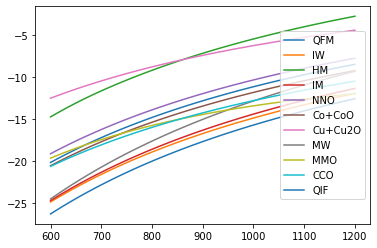

In [4]:
T = np.linspace(600,1200) + 273.15
buffers = ['QFM','IW','HM','IM','NNO','Co+CoO','Cu+Cu2O','MW','MMO','CCO','QIF']

logfO2 = eval_redox_buffers(buffers, T)

plt.figure()
for buffer in logfO2:
    plt.plot(T-273.15,logfO2[buffer], '-', label=buffer)
    
plt.legend(loc='center right')

In [5]:
Kress_dat = pd.read_csv('data/iron-redox-Kress91.dat')
for oxide in chem.OXIDE_ORDER:
    if oxide not in Kress_dat:
        Kress_dat[oxide] = 0
        
Kress_dat['T'] += 273.15

Kress_dat.head()

run-id        T    P  logfO2   SiO2  TiO2  Al2O3  Fe2O3  Cr2O3   FeO  ...  \
0  BFEQ-51  1626.95  1.0  -0.678  44.71  3.00  13.00  17.05   0.01  5.10  ...   
1  BFEQ-52  1626.95  1.0  -0.678  46.56  3.56  15.25  13.75   0.00  5.05  ...   
2  BFEQ-53  1626.95  1.0  -0.678  45.56  2.95  13.02  16.72   0.00  5.00  ...   
3  BFEQ-61  1724.25  1.0  -0.678  45.36  2.98  12.77  15.50   0.01  6.97  ...   
4  BFEQ-62  1724.25  1.0  -0.678  47.91  3.60  15.23  11.89   0.00  6.33  ...   

   CoO   CaO  Na2O   K2O  P2O5   x3   x4  unknown  H2O  CO2  
0  0.0  9.06  0.68  0.54  0.31  0.0  0.0    99.19    0    0  
1  0.0  7.48  1.10  0.85  0.38  0.0  0.0    98.96    0    0  
2  0.0  9.11  0.70  0.57  0.31  0.0  0.0    99.64    0    0  
3  0.0  9.09  0.74  0.46  0.32  0.0  0.0    99.91    0    0  
4  0.0  7.45  1.31  0.74  0.26  0.0  0.0    99.62    0    0  

[5 rows x 23 columns]

In [6]:
T = Kress_dat['T'].values
P = Kress_dat['P'].values
logfO2 = Kress_dat['logfO2'].values
wt_comp_orig = Kress_dat[chem.OXIDE_ORDER].values
oxide_comp_orig = chem.wt_to_mol_oxide(wt_comp_orig)
ind_FeO = np.where(chem.OXIDE_ORDER=='FeO')[0][0]
ind_Fe2O3 = np.where(chem.OXIDE_ORDER=='Fe2O3')[0][0]

ln_Fe_oxide_ratio = np.log(oxide_comp_orig[:,ind_Fe2O3]/oxide_comp_orig[:,ind_FeO])

In [7]:

oxide_comp = {'Liq': oxide_comp_orig.copy()}
oxide_comp

{'Liq': array([[0.52945653, 0.02671599, 0.09071902, ..., 0.00155394, 0.        ,
         0.        ],
        [0.55069209, 0.03166432, 0.10629065, ..., 0.0019025 , 0.        ,
         0.        ],
        [0.53525839, 0.0260631 , 0.09014053, ..., 0.00154166, 0.        ,
         0.        ],
        ...,
        [0.66403377, 0.00586908, 0.11140098, ..., 0.00091768, 0.        ,
         0.        ],
        [0.66637505, 0.00588977, 0.11179376, ..., 0.00092091, 0.        ,
         0.        ],
        [0.66531262, 0.00588038, 0.11161552, ..., 0.00091944, 0.        ,
         0.        ]])}

In [8]:

logfO2_mod = modelDB.redox_state(T, P, oxide_comp=oxide_comp,
                    phase_of_interest='Liq', method='Kress91')
# logfO2_mod

In [9]:
ln_Fe_oxide_ratio_mod = modelDB.redox_state(T, P, logfO2=logfO2, oxide_comp=oxide_comp,
                    phase_of_interest='Liq', method='Kress91')

Text(0, 0.5, 'residual log$_{10}$ fO$_2$')

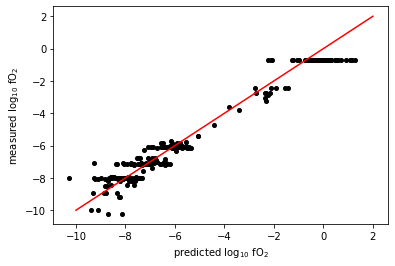

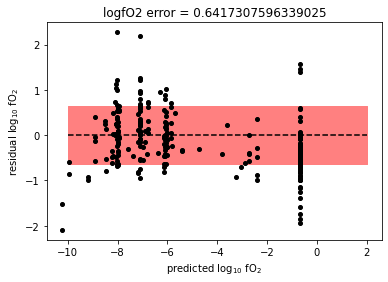

In [10]:
x = np.linspace(-10, 2, 101)
plt.figure()
plt.plot(logfO2_mod, logfO2, 'ko', markersize=4)
plt.plot(x,x,'r-')
plt.xlabel('predicted log$_{10}$ fO$_2$')
plt.ylabel('measured log$_{10}$ fO$_2$')


fO2_err = np.std(logfO2-logfO2_mod)

plt.figure()
plt.plot(logfO2, logfO2-logfO2_mod, 'ko', markersize=4)
plt.fill_between(x, -fO2_err, fO2_err, color=[1,.5,.5])
plt.title('logfO2 error = ' + str(fO2_err))
plt.plot(x, 0*x, 'k--')

plt.xlabel('predicted log$_{10}$ fO$_2$')
plt.ylabel('residual log$_{10}$ fO$_2$')


(-4.5, 1.5)

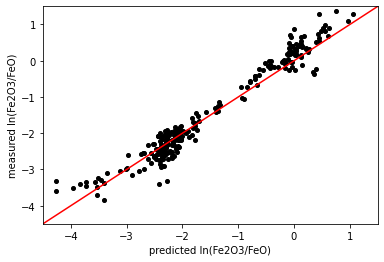

In [11]:
# plt.figure(figsize=(12,4))
plt.figure()
# ax = plt.gca()
x = np.linspace(-6,4,100)
plt.plot(ln_Fe_oxide_ratio_mod, ln_Fe_oxide_ratio, 'ko', markersize=4)
plt.plot(x, x, 'r-')
plt.xlabel('predicted ln(Fe2O3/FeO)')
plt.ylabel('measured ln(Fe2O3/FeO)')
plt.xlim(-4.5, 1.5)
plt.ylim(-4.5, 1.5)



In [12]:
XFeO_f = np.squeeze(oxide_comp['Liq'].T[chem.OXIDE_ORDER=='FeO'])
XFeO_i = np.squeeze(oxide_comp_orig.T[chem.OXIDE_ORDER=='FeO'])
XFe2O3_f = np.squeeze(oxide_comp['Liq'].T[chem.OXIDE_ORDER=='Fe2O3'])
XFe2O3_i = np.squeeze(oxide_comp_orig.T[chem.OXIDE_ORDER=='Fe2O3'])

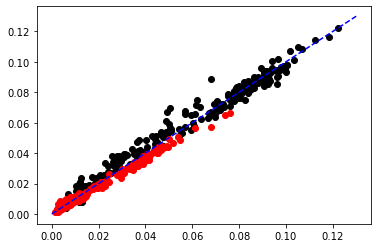

In [13]:
x = np.linspace(0,.13,101)
plt.figure()
plt.plot(XFeO_i, XFeO_f, 'ko')
plt.plot(XFe2O3_i, XFe2O3_f, 'ro')
plt.plot(x,x,'b--')

In [14]:
def Fe_redox_Kress91(T, P, mol_oxides, log10fO2=None):
    """
    Fe redox model of Kress and Carmichael 1991
    
    Calculate ln(Fe2O3/FeO) ratio given lnfO2, T, P, bulk composition.
    Alternatively, can predict lnfO2 values given measured ferric & ferrous comp.
    
    Parameters
    ----------
    T : double (array)
        temperature in Kelvin
    P : double (array)
        pressure in bars
    mol_oxides : double array (matrix)
        molar oxide composition in standard order. Either measured FeO and Fe2O3 are
        provided, or total iron reported as FeO (e.g. FeO*)
    log10fO2 : double (array), default None
        If provided, the measured log10fO2 value is used to predict the ln(Fe2O3/FeO).
        Otherwise, reported FeO and Fe2O3 values are used to predict log10fO2.
        
    Returns
    -------
     output : double (array)
         Output depends on whether log10fO2 values are provided.
         ln_Fe_oxide_ratio : If log10fO2 values are given, return log ferric/ferrous ratio of melt.
         log10fO2 : If not, return predicted log10fO2, given measured ferric and ferrous content of melt.
        
    """
    
    predict_fO2 = False
    if log10fO2 is None:
        predict_fO2 = True
    
    
    OXIDES = chem.OXIDE_ORDER
    # ['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'Cr2O3', 'FeO', 'MnO', 'MgO',
    #    'NiO', 'CoO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O', 'CO2']
    
    T0 =  1673.15  # K
    
    a  =  0.196
    b  =  1.1492e4 # K
    c  = -6.675
    e  = -3.364
    f  = -7.01e-7  * 1.0e5 # K/bar
    g  = -1.54e-10 * 1.0e5 # 1/bar
    h =   3.85e-17 * 1.0e5 * 1.0e5 # K/bar^2
    # dAl2O3 = -2.243
    # dFeO   = -1.828
    # dCaO   =  3.201
    # dNa2O  =  5.854
    # dK2O   =  6.215
    
    # mol_oxides = np.array(mol_oxides.copy())
    mol_oxides = mol_oxides.copy()
    
    XFeO_equiv = mol_oxides['FeO'] + 2*mol_oxides['Fe2O3']
    # print(mol_oxides.shape)
    # print(XFeO_equiv.shape)
    
    if predict_fO2:
        # ln_Fe_oxide_ratio = np.squeeze(np.log(mol_oxides[:, OXIDES=='Fe2O3']/mol_oxides[:, OXIDES=='FeO']))
        ln_Fe_oxide_ratio = np.squeeze(np.log(mol_oxides['Fe2O3']/mol_oxides['FeO']))
        # display(ln_Fe_oxide_ratio)
    
    mol_oxides['FeO'] = XFeO_equiv
    mol_oxides['Fe2O3'] = 0.0
    if mol_oxides.ndim==2:
        mol_oxide_tot = np.sum(mol_oxides, axis=1)
        mol_oxides /= mol_oxide_tot[:,np.newaxis]
    elif mol_oxides.ndim==1:
        mol_oxide_tot = np.sum(mol_oxides)
        mol_oxides /= mol_oxide_tot
    else:
        assert False, 'mol_oxides must be either an array of compositions, or a matrix for many experiments'
        
    
    d = pd.Series(np.zeros(len(OXIDES)),index=OXIDES)
    d['Al2O3'] = -2.243
    d['FeO']   = -1.828
    d['CaO']   = +3.201
    d['Na2O']  = +5.854
    d['K2O']   = +6.215
    
    atm_terms = b/T + c + e*(1.0-T0/T - np.log(T/T0))
    press_terms = f*P/T + g*(T-T0)*P/T+ h*P*P/T
    comp_terms = np.dot(mol_oxides, d)
    
    if not predict_fO2:
        lnfO2 = log10fO2/np.log10(np.exp(1))
        ln_Fe_oxide_ratio =  a*lnfO2 + atm_terms + press_terms + comp_terms
        return ln_Fe_oxide_ratio
    else:
        # print(ln_Fe_oxide_ratio )
        # print((atm_terms + press_terms + comp_terms))
        lnfO2 = (ln_Fe_oxide_ratio - (atm_terms + press_terms + comp_terms))/a
        log10fO2 = lnfO2*np.log10(np.exp(1))
        return log10fO2
        



    # FeOxideRatio = np.exp(ln_Fe_oxide_ratio)
    # 
    # XFeO = XFeO_equiv/(2*FeOxideRatio + 1)
    # XFe2O3 = 0.5*(XFeO_equiv-XFeO)
    # 
    # mol_oxides[OXIDES=='FeO'] = XFeO
    # mol_oxides[OXIDES=='Fe2O3'] = XFe2O3
    # return mol_oxides

In [15]:
def _eval_linear_buffer(T, P, A=None, B=None, C=None, Tlims=None, ignore_lims=False):
    """
    Evaluate fO2 values using linear buffer model (linear dependence in 1/T and P).
    
    Parameters
    ----------
    T : double (array)
        temperature in Kelvin
    P : double (array)
        pressure in bars
    A : double
        1/T coefficient
    B : double
        Offset term
    C : double
        P/T coefficient
    Tlims : double range, default None
        If provided, Tlims gives the limits of the buffer model. Outside these limits,
        buffer returns NaN values.
    
    Returns
    -------
    logfO2 : double (array)
        absolute logfO2 in base 10
    """
    logfO2 = A/T + B + C*(P-1)/T
    
    if (not ignore_lims) and (Tlims is not None):
        logfO2[T<Tlims[0]] = np.nan
        logfO2[T>=Tlims[1]] = np.nan
    
    return logfO2 
    
def fO2_buffer(T, P, buffer=None, ignore_lims=False):
    """
    Calculate fO2 values for common oxygen buffers.
    
    Parameters
    ----------
    T : double (array)
        temperature in Kelvin
    P : double (array)
        pressure in bars
    buffer : {'IW', 'IM', 'NNO', 'CCO', ('HM'/'MH'), ('MW'/'WM'), ('QFM'/'FMQ'), 'QIF'}
        models of common oxygen fugacity buffer systems with sources.
        'IW' : Iron-Wustite [1]
        'IM' : Iron-Magnetite [1]
        'NNO' : Nickel-Nickel Oxide [1]
        'CCO' : Cobalt-Cobalt Oxide [1]
        'HM' or 'MH' : Magnetite-Hematite [1]
        'MW' or 'WM' : Magnetite-Wustite [1]
        'QFM' or 'FMQ' : Quartz-Fayalite-Magnetite [1]
        'QIF' : Quartz-Iron-Fayalite [1]
        
    Returns
    -------
    log10fO2 : double (array)
        logfO2 in base 10
        
        
    Publication Sources
    -------------------
    [1] B. R. Frost (1991) Introduction to oxygen fugacity and its petrologic importance    
    
    """
    
    BUFFER_OPTS = ['IW', 'IM', 'NNO', 'CCO', 'HM', 'MH', 'MW', 'WM', 'QFM', 'FMQ', 'QIF']
    assert buffer in BUFFER_OPTS, (
        'Selected buffer ' + buffer + ' is not available. Please select from ' + str(BUFFER_OPTS)
    )
    
    if buffer=='IW':
        # Frost (1991)
        logfO2 = _eval_linear_buffer(T, P, A=-27489, B=6.702, C=.055, 
                                     Tlims=np.array([565, 1200])+273.15, ignore_lims=ignore_lims)
    elif buffer=='IM':
        logfO2 = _eval_linear_buffer(T, P, A=-28690.6, B=8.13, C=.056, Tlims=np.array([300, 565])+273.15, ignore_lims=ignore_lims)
    elif buffer=='NNO':
        logfO2 = _eval_linear_buffer(T, P, A=-24930, B=9.36, C=.046, Tlims=np.array([600, 1200])+273.15, ignore_lims=ignore_lims)
    elif buffer=='CCO':
        logfO2 = _eval_linear_buffer(T, P, A=-24332.6, B=7.295, C=.052, Tlims=np.array([600, 1200])+273.15, ignore_lims=ignore_lims)
    elif buffer in ['HM', 'MH']:
        logfO2_T1 = _eval_linear_buffer(T, P, A=-25497.5, B=14.33, C=.019, Tlims=np.array([300, 573])+273.15, ignore_lims=ignore_lims)
        logfO2_T2 = _eval_linear_buffer(T, P, A=-26452.6, B=15.455, C=.019, Tlims=np.array([573, 682])+273.15, ignore_lims=ignore_lims)
        logfO2_T3 = _eval_linear_buffer(T, P, A=-25700.6, B=14.558, C=.019, Tlims=np.array([682, 1100])+273.15, ignore_lims=ignore_lims)
        
        logfO2 = np.vstack((logfO2_T1, logfO2_T2, logfO2_T3))
        logfO2 = np.nanmean(logfO2, axis=0)
    elif buffer in ['MW', 'WM']:
        logfO2 = _eval_linear_buffer(T, P, A=-32807, B=13.012, C=.083, Tlims=np.array([565, 1200])+273.15, ignore_lims=ignore_lims)
    elif buffer in ['QFM', 'FMQ']:
        logfO2_T1 = _eval_linear_buffer(T, P, A=-26455.3, B=10.344, C=.092, Tlims=np.array([400, 573])+273.15, ignore_lims=ignore_lims)
        logfO2_T2 = _eval_linear_buffer(T, P, A=-25096.3, B=8.735, C=.110, Tlims=np.array([573, 1200])+273.15, ignore_lims=ignore_lims)
        
        logfO2 = np.vstack((logfO2_T1, logfO2_T2))
        logfO2 = np.nanmean(logfO2, axis=0)
    elif buffer=='QIF':
        logfO2_T1 = _eval_linear_buffer(T, P, A=-29435.7, B=7.391, C=.044, Tlims=np.array([150, 573])+273.15, ignore_lims=ignore_lims)
        logfO2_T2 = _eval_linear_buffer(T, P, A=-29520.8, B=7.492, C=.05, Tlims=np.array([573, 1200])+273.15, ignore_lims=ignore_lims)
    
        logfO2 = np.vstack((logfO2_T1, logfO2_T2))
        logfO2 = np.nanmean(logfO2, axis=0)
        

    return logfO2
        
    

In [16]:
T = np.linspace(200, 1200,1001)+273.15
P0 = 1
P1 = 2e4
ignore_lims=True
# ignore_lims=False

BUFFER_LIST = ['IW', 'IM', 'NNO', 'CCO', 'MH', 'MW', 'QFM', 'QIF']
logfO2_0 = {}
logfO2_1 = {}
for buffer in BUFFER_LIST:
    logfO2_0[buffer] = fO2_buffer(T, P0, buffer=buffer, ignore_lims=ignore_lims)
    logfO2_1[buffer] = fO2_buffer(T, P1, buffer=buffer, ignore_lims=ignore_lims)

Text(0.5, 1.0, 'Common fO2 buffers at 1bar and 2 GPa [*]')

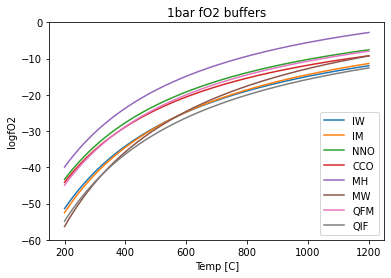

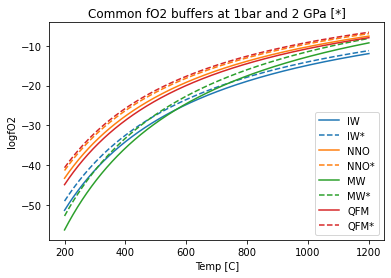

In [17]:
plt.figure()
for ibuffer,ilogfO2_0 in logfO2_0.items():
    lines = plt.plot(T-273.15, ilogfO2_0, '-', label=ibuffer)
    
plt.legend()
plt.xlabel('Temp [C]')
plt.ylabel('logfO2')

plt.ylim(-60,0)
plt.title('1bar fO2 buffers')

plt.figure()

for ibuffer in ['IW', 'NNO', 'MW', 'QFM']:
    ilogfO2_0 = logfO2_0[ibuffer]
    ilogfO2_1 = logfO2_1[ibuffer]
    lines = plt.plot(T-273.15, ilogfO2_0, '-', label=ibuffer)
    plt.plot(T-273.15, ilogfO2_1, '--', label=ibuffer+'*', color=lines[0].get_color())
    
plt.legend()
plt.xlabel('Temp [C]')
plt.ylabel('logfO2')
plt.title('Common fO2 buffers at 1bar and 2 GPa [*]')

In [18]:
Kress_dat = pd.read_csv('data/iron-redox-Kress91.dat')
for oxide in chem.OXIDE_ORDER:
    if oxide not in Kress_dat:
        Kress_dat[oxide] = 0
        
Kress_dat['T'] += 273.15

Kress_dat.head()

run-id        T    P  logfO2   SiO2  TiO2  Al2O3  Fe2O3  Cr2O3   FeO  ...  \
0  BFEQ-51  1626.95  1.0  -0.678  44.71  3.00  13.00  17.05   0.01  5.10  ...   
1  BFEQ-52  1626.95  1.0  -0.678  46.56  3.56  15.25  13.75   0.00  5.05  ...   
2  BFEQ-53  1626.95  1.0  -0.678  45.56  2.95  13.02  16.72   0.00  5.00  ...   
3  BFEQ-61  1724.25  1.0  -0.678  45.36  2.98  12.77  15.50   0.01  6.97  ...   
4  BFEQ-62  1724.25  1.0  -0.678  47.91  3.60  15.23  11.89   0.00  6.33  ...   

   CoO   CaO  Na2O   K2O  P2O5   x3   x4  unknown  H2O  CO2  
0  0.0  9.06  0.68  0.54  0.31  0.0  0.0    99.19    0    0  
1  0.0  7.48  1.10  0.85  0.38  0.0  0.0    98.96    0    0  
2  0.0  9.11  0.70  0.57  0.31  0.0  0.0    99.64    0    0  
3  0.0  9.09  0.74  0.46  0.32  0.0  0.0    99.91    0    0  
4  0.0  7.45  1.31  0.74  0.26  0.0  0.0    99.62    0    0  

[5 rows x 23 columns]

In [19]:
mol_oxides = chem.wt_to_mol_oxide(Kress_dat[chem.OXIDE_ORDER])
mol_oxides = pd.DataFrame(mol_oxides, columns=chem.OXIDE_ORDER)
ln_oxide_ratio = np.log(mol_oxides['Fe2O3']/mol_oxides['FeO'])

In [20]:
T = Kress_dat['T']
P = Kress_dat['P']
log10fO2 = Kress_dat['logfO2']
ln_oxide_ratio_model = Fe_redox_Kress91(T, P, mol_oxides, log10fO2=log10fO2)

(-4.5, 1.5)

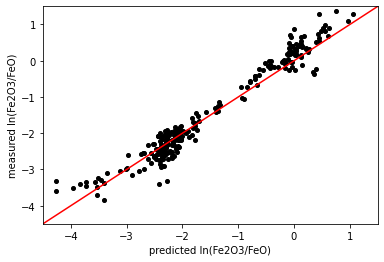

In [21]:
# plt.figure(figsize=(12,4))
plt.figure()
# ax = plt.gca()
x = np.linspace(-6,4,100)
plt.plot(ln_oxide_ratio_model, ln_oxide_ratio, 'ko', markersize=4)
plt.plot(x, x, 'r-')
plt.xlabel('predicted ln(Fe2O3/FeO)')
plt.ylabel('measured ln(Fe2O3/FeO)')
plt.xlim(-4.5, 1.5)
plt.ylim(-4.5, 1.5)



In [22]:
T = Kress_dat['T']
P = Kress_dat['P']
log10fO2 = Kress_dat['logfO2']
log10fO2_model = Fe_redox_Kress91(T, P, mol_oxides)

Text(0, 0.5, 'residual log$_{10}$ fO$_2$')

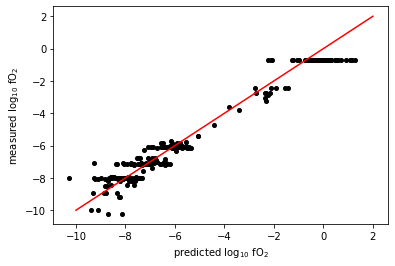

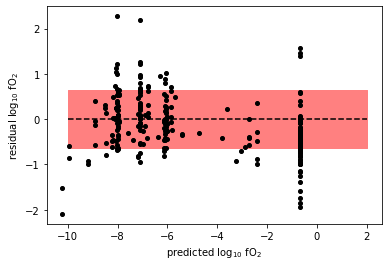

In [23]:
x = np.linspace(-10, 2, 101)
plt.figure()
plt.plot(log10fO2_model, log10fO2, 'ko', markersize=4)
plt.plot(x,x,'r-')
plt.xlabel('predicted log$_{10}$ fO$_2$')
plt.ylabel('measured log$_{10}$ fO$_2$')


fO2_err = np.std(log10fO2-log10fO2_model)

plt.figure()
plt.plot(log10fO2, log10fO2-log10fO2_model, 'ko', markersize=4)
plt.fill_between(x, -fO2_err, fO2_err, color=[1,.5,.5])
plt.plot(x, 0*x, 'k--')

plt.xlabel('predicted log$_{10}$ fO$_2$')
plt.ylabel('residual log$_{10}$ fO$_2$')


In [24]:
adiabat_fO2 = pd.read_excel('data/adiabat_fO2_Kress91.xlsx', sheet_name=None)
dTdP_ad = 15

In [25]:
liq_comp = adiabat_fO2['Liq_comp']
Fe3_ratio = liq_comp['Fe+3/Fe_tot']

for oxide in chem.OXIDE_ORDER:
    if oxide not in liq_comp:
        liq_comp[oxide] = 0.0

liq_comp[chem.OXIDE_ORDER]

SiO2  TiO2  Al2O3  Fe2O3  Cr2O3    FeO   MnO  MgO  NiO  CoO    CaO  Na2O  \
0  50.95  1.88  13.99    0.0    0.0  12.22  0.22  6.5  0.0  0.0  10.96  2.62   

   K2O  P2O5   H2O  CO2  
0  0.2  0.22  0.45  0.0

In [26]:

print(Fe3_ratio)


mol_oxides_ad = chem.wt_to_mol_oxide(liq_comp[chem.OXIDE_ORDER])
mol_oxides_ad = pd.DataFrame(mol_oxides_ad, columns=chem.OXIDE_ORDER)
mol_oxides_ad

0    0.167
Name: Fe+3/Fe_tot, dtype: float64


SiO2      TiO2     Al2O3  Fe2O3  Cr2O3       FeO       MnO       MgO  \
0  0.526843  0.014619  0.085248    0.0    0.0  0.105674  0.001927  0.100199   

   NiO  CoO       CaO      Na2O       K2O      P2O5       H2O  CO2  
0  0.0  0.0  0.121425  0.026264  0.001319  0.000963  0.015519  0.0

In [27]:

FeOs = mol_oxides_ad['FeO']
print(FeOs)
print(FeOs*Fe3_ratio)
Fe3 = Fe3_ratio*FeOs
mol_oxides_ad['Fe2O3'] = 0.5*Fe3
mol_oxides_ad['FeO'] = FeOs-Fe3
mol_oxides_ad

0    0.105674
Name: FeO, dtype: float64
0    0.017648
dtype: float64


SiO2      TiO2     Al2O3     Fe2O3  Cr2O3       FeO       MnO  \
0  0.526843  0.014619  0.085248  0.008824    0.0  0.088026  0.001927   

        MgO  NiO  CoO       CaO      Na2O       K2O      P2O5       H2O  CO2  
0  0.100199  0.0  0.0  0.121425  0.026264  0.001319  0.000963  0.015519  0.0

In [28]:
2*.008824+.088026

0.10567399999999999

In [29]:
P = 1e4*np.linspace(0,3,101)
Tpot = 1350+273.15
# Tpot = 1350+190
T = Tpot+dTdP_ad*P/1e4

logfO2_NNO = fO2_buffer(T, P, buffer='NNO', ignore_lims=True)
logfO2_FMQ = fO2_buffer(T, P, buffer='FMQ', ignore_lims=True)
log10fO2_liq = Fe_redox_Kress91(T, P, mol_oxides_ad)

In [30]:
fO2_buffer(1350+273.15, 1, buffer='FMQ', ignore_lims=True)

array([-6.34060966])

In [31]:
fO2_buffer(1350+273.15, 1, buffer='NNO', ignore_lims=True)

-5.999024119767119

In [32]:
# T= 1350+273.15
# P=1
# (-25018.7/T + 12.981 + 0.046*(P-1.0)/T -0.5117*np.log(T))

In [33]:
web_MELTS = pd.DataFrame()
web_MELTS['T'] = [1350, 1365, 1380, 1395]
web_MELTS['P'] = [1, 1.00E+04, 2.00E+04, 3.00E+04]
web_MELTS['logfO2'] = [-6.77, -5.73, -4.81, -4.01]
web_MELTS

T        P  logfO2
0  1350      1.0   -6.77
1  1365  10000.0   -5.73
2  1380  20000.0   -4.81
3  1395  30000.0   -4.01

Text(0, 0.5, 'log$_{10}$fO$_2$')

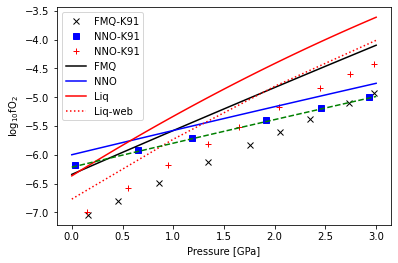

In [34]:

plt.figure()
plt.plot(adiabat_fO2['FMQ']['P'],adiabat_fO2['FMQ']['fO2'],'kx', label='FMQ-K91')
plt.plot(adiabat_fO2['NNO']['P'],adiabat_fO2['NNO']['fO2'],'bs', label='NNO-K91')
plt.plot(adiabat_fO2['Liq']['P'],adiabat_fO2['Liq']['fO2'],'r+', label='NNO-K91')
plt.plot(P/1e4,logfO2_FMQ,'k-', label='FMQ')
plt.plot(P/1e4,logfO2_NNO,'b-', label='NNO')
plt.plot(P/1e4, log10fO2_liq, 'r-', label='Liq')
plt.plot(web_MELTS['P']/1e4, web_MELTS['logfO2'], 'r:', label='Liq-web')

plt.plot(P/1e4,(-25018.7/T + 12.981 + 0.046*(P-1.0)/T -0.5117*np.log(T)), 'g--')

plt.legend()
plt.xlabel('Pressure [GPa]')
plt.ylabel('log$_{10}$fO$_2$')

In [35]:
wt_oxides = np.array([50.74, 1.87, 13.93 ,1.94 ,10.43 ,0.22 ,6.47 ,10.92 ,2.61 ,0.20 ,0.22 ,0.45])
oxide_names = ['SiO2','TiO2','Al2O3','Fe2O3','FeO','MnO','MgO','CaO','Na2O','K2O','P2O5','H2O']


Tref = 1350+273.15
Pref = 1
fO2ref = -6.77 # ==QFM
oxides = {'SiO2':50.74,'TiO2':1.87,'Al2O3':13.93,'Fe2O3':1.94,'FeO':10.43,
          'MnO':0.22,'MgO':6.47,'CaO':10.92,'Na2O':2.61,'K2O':0.20,'P2O5':0.22,'H2O':0.45}

print(len(wt_oxides))
print(len(oxide_names))
mol_oxide_comp_web = chem.format_mol_oxide_comp(oxides, convert_grams_to_moles=True)
# Fe_redox_Kress91(T, P, mol_oxide_comp_web)
pd.DataFrame(pd.Series(mol_oxide_comp_web,index=chem.OXIDE_ORDER)).T

12
12


SiO2      TiO2    Al2O3     Fe2O3  Cr2O3       FeO       MnO       MgO  \
0  0.844473  0.023405  0.13662  0.012148    0.0  0.145171  0.003101  0.160528   

   NiO  CoO       CaO      Na2O       K2O     P2O5       H2O  CO2  
0  0.0  0.0  0.194724  0.042111  0.002123  0.00155  0.024979  0.0

In [36]:
(mol_oxide_comp_web).shape
Fe_redox_Kress91(Tref, Pref, pd.DataFrame(pd.Series(mol_oxide_comp_web,index=chem.OXIDE_ORDER)).T)

array([-6.76641092])

In [37]:

Fe_redox_Kress91(1395+273.15, 3e4, pd.DataFrame(pd.Series(mol_oxide_comp_web,index=chem.OXIDE_ORDER)).T)

array([-4.0098021])

In [38]:
mol_oxides_ad

SiO2      TiO2     Al2O3     Fe2O3  Cr2O3       FeO       MnO  \
0  0.526843  0.014619  0.085248  0.008824    0.0  0.088026  0.001927   

        MgO  NiO  CoO       CaO      Na2O       K2O      P2O5       H2O  CO2  
0  0.100199  0.0  0.0  0.121425  0.026264  0.001319  0.000963  0.015519  0.0